## Final Project: Applying Python for Business Analytics

Introduction: Business problem (objective of the analysis)

The real estate industry is dynamic and influenced by various factors such as market trends, economic conditions, and location-specific dynamics. Analyzing historical real estate sales data can provide valuable insights for businesses and stakeholders in the industry. In this project, we aim to leverage a dataset containing real estate sales data from 2001 to 2020 to address key business questions and make data-driven decisions.

Business Problem/Objective:

1. Market Trends and Price Analysis: Identify and understand the overall trends and patterns in real estate within Connecticut sales over the years. Analyze changes in the assessed value, sale amount, and sales ratio to gain insights into the market dynamics and price fluctuations. This information can help businesses assess the competitiveness of different areas, track market trends, and make pricing decisions.

2. Property and Residential Type Analysis: Investigate the distribution of property types and residential types within the dataset. Determine which property types (e.g., residential, commercial, land) and residential types (e.g., single-family, multi-family, condominiums) are most prevalent in the dataset. This analysis can provide valuable information for developers, investors, and real estate agents to identify market niches and understand customer preferences.

3. Applying Models: Utilize various predictive modeling techniques such as Linear Regression, Decision Tree, and Logistic Regression to analyze the real estate sales data. By building these models, we aim to predict and understand the factors that influence the sale amount or assessed value of properties. This analysis can help businesses and stakeholders make informed decisions regarding pricing strategies, investment opportunities, and market forecasting. 

### 0. Importing libraries

In [1]:
#Importing Libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

### 1. Data & Data Wrangling

In [2]:
dtype_options = {
    'Serial Number': int,
    'List Year': int,
    'Date Recorded': str,
    'Town': str,
    'Address': str,
    'Assessed Value': float,
    'Sale Amount': float,
    'Sales Ratio': float,
    'Property Type': str,
    'Residential Type': str,
    'Non Use Code': str,
    'Assessor Remarks': str,
    'OPM remarks': str,
    'Location': str
}

df = pd.read_csv(r"C:\Users\nguye\Downloads\Real_Estate_Sales_2001-2020_GL.csv", dtype=dtype_options, low_memory=False)
df['Date Recorded'] = pd.to_datetime(df['Date Recorded'])

df.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020348,2020,2021-09-13,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
1,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,NaN,NaN,NaN,NaN
2,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,NaN,NaN,NaN,NaN
3,200243,2020,2021-04-13,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,NaN,NaN,NaN,NaN
4,200377,2020,2021-07-02,Avon,70 FAR HILLS DRIVE,862330.0,1447500.0,0.5957,Residential,Single Family,NaN,NaN,NaN,NaN


In [3]:
#Get the number of rows and columns
df.shape

(997213, 14)

In [4]:
# Check the number of missing values in each column
num_missing = df.isna().sum()

# Get the column names from the DataFrame
columns = df.columns

# Print the column names and the number of missing values
for column in columns:
    num_na = num_missing[column]
    print(f"Column: {column}, Number of missing values: {num_na}")

Column: Serial Number, Number of missing values: 0
Column: List Year, Number of missing values: 0
Column: Date Recorded, Number of missing values: 2
Column: Town, Number of missing values: 0
Column: Address, Number of missing values: 51
Column: Assessed Value, Number of missing values: 0
Column: Sale Amount, Number of missing values: 0
Column: Sales Ratio, Number of missing values: 0
Column: Property Type, Number of missing values: 382446
Column: Residential Type, Number of missing values: 388309
Column: Non Use Code, Number of missing values: 707532
Column: Assessor Remarks, Number of missing values: 847349
Column: OPM remarks, Number of missing values: 987279
Column: Location, Number of missing values: 799516


#### Since there are alot of rows and columns with NA value, we will need to get rid of them.

In [5]:
#Fixing Property Column
df.loc[df['Property Type'] == 'Residential', 'Property Type'] = df.loc[df['Property Type'] == 'Residential', 'Residential Type']

# Drop the columns from 'Residential Type' to 'Location'
df = df.drop(columns=df.columns[df.columns.get_loc('Residential Type'):df.columns.get_loc('Location')+1])
# Drop the Serial number
df = df.drop("Serial Number", axis=1)
# Drop the Address
df = df.drop("Address", axis=1)
# Drop the Recorded date
df = df.drop("Date Recorded", axis=1)

#Removing outliers
# Calculate the lower and upper boundaries for outlier detection for each column
columns = ['Assessed Value', 'Sale Amount', 'Sales Ratio']
bounds = {}
for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    bounds[column] = (lower_bound, upper_bound)

# Filter and remove the rows containing outliers for each column
outliers = pd.DataFrame()
for column in columns:
    lower_bound, upper_bound = bounds[column]
    column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers = pd.concat([outliers, column_outliers])
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]



# Remove rows with missing values
data_clean = df.dropna()

#Create second data copy for later use
data_log = data_clean.copy()


### 2. Preliminary Analysis

In [6]:
# Summary statistics for numerical columns
data_clean.describe()

,List Year,Assessed Value,Sale Amount,Sales Ratio
count,492842.000000,492842.000000,492842.000000,492842.000000
mean,2013.894516,167776.762758,255215.867511,0.685746
std,4.530202,84902.194562,130361.174181,0.187036
min,2006.000000,190.000000,2000.000000,0.038854
25%,2010.000000,107940.000000,160000.000000,0.577300
50%,2015.000000,151360.000000,230000.000000,0.670700
75%,2018.000000,214620.000000,329000.000000,0.782143
max,2020.000000,432500.000000,702500.000000,1.233120


In [7]:
#correlations for numeric columns
corr_matrix = data_clean.corr(numeric_only=True)
corr_matrix

,List Year,Assessed Value,Sale Amount,Sales Ratio
List Year,1.000000,-0.030959,0.021106,-0.093850
Assessed Value,-0.030959,1.000000,0.850676,0.172135
Sale Amount,0.021106,0.850676,1.000000,-0.296908
Sales Ratio,-0.093850,0.172135,-0.296908,1.000000


#### A correlation coefficient of 0.850676 indicates that there is a strong linear relationship between the "Assessed Value" and "Sale Amount" columns. As the "Assessed Value" increases, the "Sale Amount" tends to increase as well, and vice versa.

#### This positive correlation suggests that there is a tendency for higher assessed values to be associated with higher sale amounts, which implies that the assessed value of a property may be a good indicator of its sale price.

In [8]:
#Summary statistics for categorical columns:
town_counts = data_clean['Town'].value_counts()
property_type_counts = data_clean['Property Type'].value_counts()
print(town_counts)
print(property_type_counts)

Town
Waterbury        13266
Bridgeport       13126
Stamford         11454
Norwalk          11202
West Hartford    11197
                 ...  
Bridgewater        185
Canaan             178
Roxbury            176
Union              100
***Unknown***        1
Name: count, Length: 170, dtype: int64
Property Type
Single Family     350890
Condo             104389
Two Family         22107
Three Family       10307
Vacant Land         2151
Four Family         1681
Commercial           949
Apartments           279
Industrial            86
Public Utility         3
Name: count, dtype: int64


In [9]:
cross_tab = pd.crosstab(data_clean['Property Type'], data_clean['Town'])
cross_tab_sorted = cross_tab.sort_values(by='Property Type', ascending=False)
print("Cross-Tabulation:")
print(cross_tab_sorted)

chi2, p, _, _ = chi2_contingency(cross_tab)
print("\nChi-square test p-value:")
print(p)

#Removing Town column as this point due to no longer needed.
data_clean = data_clean.drop("Town", axis=1)

#The chi-square test p-value is 0.0, indicating that there is a significant association between the 'Property Type' and 'Town' variables. 
#This suggests that the distribution of property types varies significantly across different towns.

Cross-Tabulation:
Town            ***Unknown***  Andover  Ansonia  Ashford  Avon  Barkhamsted  \
Property Type                                                                 
Vacant Land                 0        6        7        8    16           11   
Two Family                  0        5      521       13     2            4   
Three Family                0        0      125        0     2            1   
Single Family               1      459     1690      599  2143          500   
Public Utility              0        0        0        0     0            0   
Industrial                  0        0        1        0     1            0   
Four Family                 0        0       28        0     0            0   
Condo                       0        0       81       23  1329            0   
Commercial                  0        0        6        2     3            1   
Apartments                  0        0        2        0     0            0   

Town            Beacon Falls  Ber

In [10]:
# Handling Text and Categorical Attributes
data_clean["Property Type"] = data_clean["Property Type"].str.strip()
data_clean["Property Type"] = data_clean["Property Type"].str.lower()
data_clean_pt = data_clean[["Property Type"]]
ordinal_encoder = OrdinalEncoder()
data_clean_pt_encoded = ordinal_encoder.fit_transform(data_clean_pt)

pt_encoder = OneHotEncoder()
data_clean_pt_1hot = pt_encoder.fit_transform(data_clean_pt)

In [11]:
#Get the encoded column
pt_encoder.categories_

[array(['apartments', 'commercial', 'condo', 'four family', 'industrial',
        'public utility', 'single family', 'three family', 'two family',
        'vacant land'], dtype=object)]

In [12]:
#Assign columsn
pt_columns = pd.DataFrame(data_clean_pt_1hot.toarray(), columns=['apartments', 'commercial', 'condo', 'four family', 'industrial',
        'public utility', 'single family', 'three family', 'two family',
        'vacant land'])

#Reset index to avoid missing value error
data_clean.reset_index(drop=True, inplace=True)
pt_columns.reset_index(drop=True, inplace=True)

#Joining Data
data_clean = data_clean.join(pt_columns)
data_clean = data_clean.drop("Property Type", axis=1)

### 3. Visual Inspection of the Data

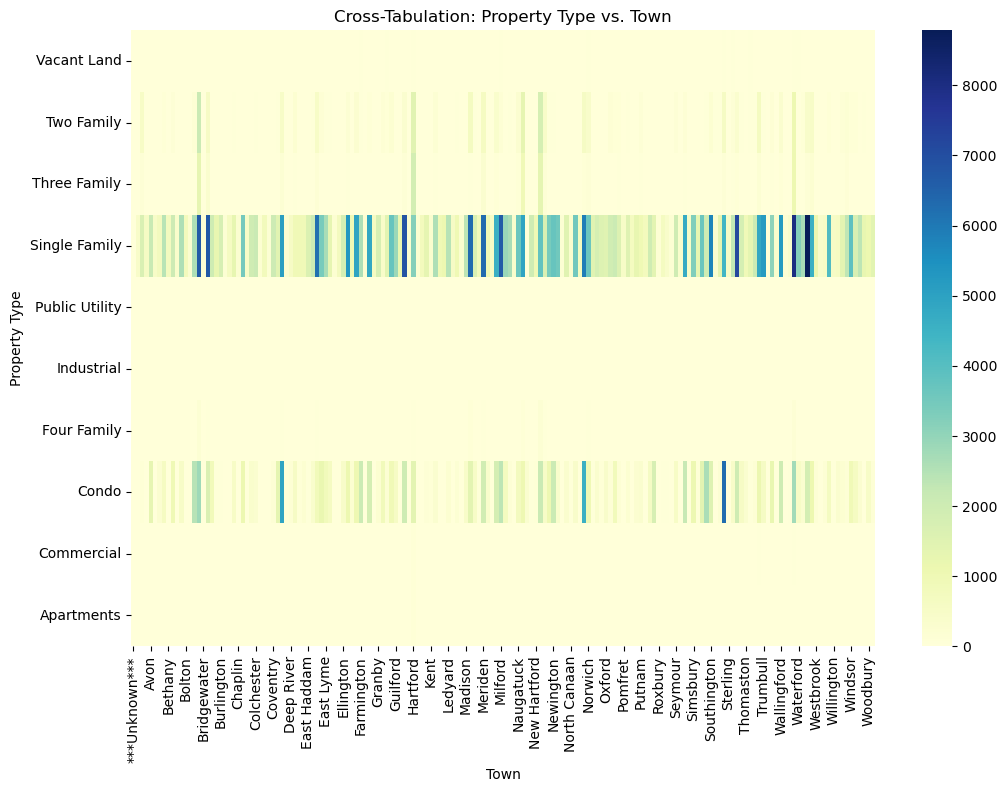

In [13]:
cross_tab = pd.crosstab(data_log['Property Type'], data_log['Town'])
cross_tab_sorted = cross_tab.sort_values(by='Property Type', ascending=False)

# Create a heatmap of the cross-tabulation table
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab_sorted, cmap='YlGnBu')
plt.title('Cross-Tabulation: Property Type vs. Town')
plt.xlabel('Town')
plt.ylabel('Property Type')
plt.show()

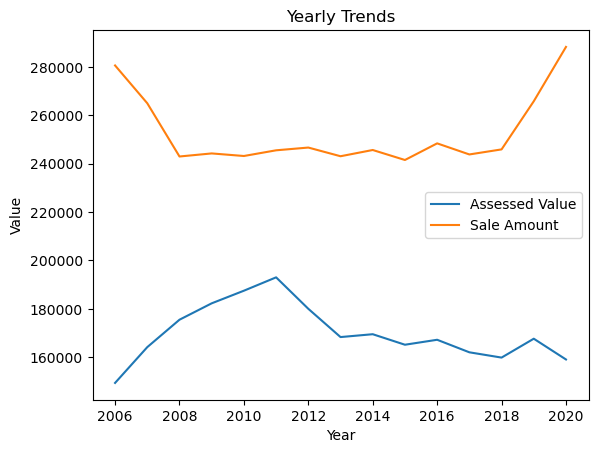

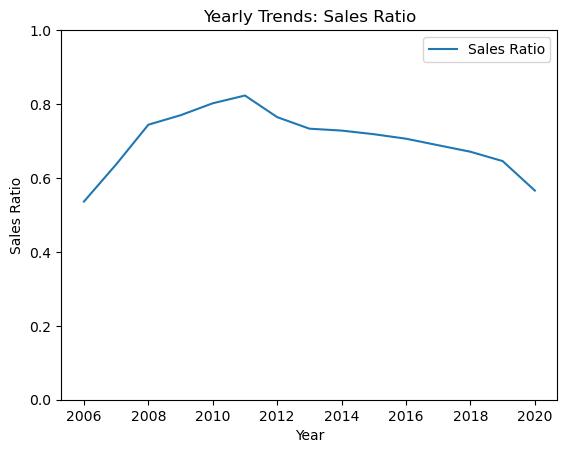

In [14]:
yearly_data = data_clean[['List Year', 'Assessed Value', 'Sale Amount', 'Sales Ratio']]

start_year = 2006
end_year = 2020
yearly_data = yearly_data[(yearly_data['List Year'] >= start_year) & (yearly_data['List Year'] <= end_year)]
yearly_data = yearly_data.groupby('List Year').mean()

# Plot the yearly trends for Assessed Value, Sale Amount, and Sales Ratio
plt.plot(yearly_data.index, yearly_data['Assessed Value'], label='Assessed Value')
plt.plot(yearly_data.index, yearly_data['Sale Amount'], label='Sale Amount')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Yearly Trends')
plt.legend()

# Show the plot
plt.show()


# Create a separate plot for the Sales Ratio
plt.plot(yearly_data.index, yearly_data['Sales Ratio'], label='Sales Ratio')

# Customize the plot for Sales Ratio
plt.xlabel('Year')
plt.ylabel('Sales Ratio')
plt.title('Yearly Trends: Sales Ratio')
plt.ylim(0, 1)
plt.legend()

# Show the plot for Sales Ratio
plt.show()

### 4. Main analysis: Linear Regression, Decision Tree, and Logistics Regression

#### a. Creating training/testing data

In [15]:
train_set, test_set = train_test_split(data_clean, test_size=0.3, random_state=23)
train_set

,List Year,Assessed Value,Sale Amount,Sales Ratio,apartments,commercial,condo,four family,industrial,public utility,single family,three family,two family,vacant land
169613,2010,128350.0,131600.0,0.975304,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
343563,2016,170240.0,308000.0,0.552727,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
402637,2018,97400.0,130000.0,0.749200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18456,2020,66920.0,180000.0,0.371700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
446628,2019,96320.0,287000.0,0.335600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338870,2015,190570.0,290000.0,0.657138,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
223177,2012,219900.0,263000.0,0.836122,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
271400,2014,135100.0,122000.0,1.107377,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127718,2008,211260.0,195000.0,1.083385,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
test_set

,List Year,Assessed Value,Sale Amount,Sales Ratio,apartments,commercial,condo,four family,industrial,public utility,single family,three family,two family,vacant land
352561,2016,186000.0,281000.0,0.661922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
314859,2015,110250.0,125000.0,0.882000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126277,2008,432100.0,525000.0,0.823048,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
211847,2012,335860.0,400000.0,0.839650,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
318933,2015,130900.0,145000.0,0.902759,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250064,2013,149940.0,252000.0,0.595000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
274521,2014,116500.0,120000.0,0.970833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
431043,2018,130800.0,215509.0,0.606900,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267272,2014,73850.0,75000.0,0.984667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
data_clean_train_X = train_set.drop("Sale Amount", axis=1) # drop labels for training set
data_clean_train_y = train_set["Sale Amount"].copy()
data_clean_test_X = test_set.drop("Sale Amount", axis=1) # drop labels for training set
data_clean_test_y = test_set["Sale Amount"].copy()


####  b. Applying Linear Regression Model

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(data_clean_train_X, data_clean_train_y)

LinearRegression()

In [19]:
# Regression coefficients
lin_reg.coef_

array([ 1.82941033e+02,  1.42293056e+00, -3.17714090e+05,  2.87781289e+04,
        5.86239845e+03, -6.54940659e+03,  5.70936212e+03,  1.88491695e+04,
       -3.82605689e+04, -3.03664087e+03, -1.62200310e+03, -1.03373297e+03,
       -8.69670655e+03])

In [20]:
pd.DataFrame(lin_reg.coef_, index = data_clean_train_X.columns)

,0
List Year,182.941033
Assessed Value,1.422931
Sales Ratio,-317714.089600
apartments,28778.128878
commercial,5862.398445
condo,-6549.406588
four family,5709.362123
industrial,18849.169524
public utility,-38260.568899
single family,-3036.640865


In [21]:
#In Sample evaluation - Linear Regression
linear_train_predictions = lin_reg.predict(data_clean_train_X)
lin_mse = mean_squared_error(data_clean_train_y, linear_train_predictions)
lin_train_rmse = np.sqrt(lin_mse)
print("In Sample RMSE: ",lin_train_rmse)

In Sample RMSE:  35325.44614118062


In [22]:
# oOt-of-sample evaluation - Linear Regression
linear_predictions = lin_reg.predict(data_clean_test_X)
lin_mse = mean_squared_error(data_clean_test_y, linear_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Out of Sample RMSE: ", lin_rmse)

Out of Sample RMSE:  35410.47420528373


In [24]:
actual_sales = pd.DataFrame(data_clean_train_y).reset_index(drop=True)
comparison_lin = pd.DataFrame(linear_predictions).round().join(actual_sales).rename(columns={0:'Predicted Sale Amount'})

print(comparison_lin)


        Predicted Sale Amount  Sale Amount
0                    291678.0     131600.0
1                    108270.0     308000.0
2                    587203.0     130000.0
3                    445717.0     180000.0
4                    134571.0     287000.0
...                       ...          ...
147848               259077.0     317000.0
147849                94273.0      84400.0
147850               225463.0     254000.0
147851                23674.0     438000.0
147852               353218.0     280000.0

[147853 rows x 2 columns]


#### b. Applying Decision Tree Model

In [90]:
#In Sample evaluation - Tree Model
tree_reg = DecisionTreeRegressor(random_state=23)
tree_reg.fit(data_clean_train_X, data_clean_train_y)
tree_train_predictions = tree_reg.predict(data_clean_train_X)
tree_mse = mean_squared_error(data_clean_train_y, tree_train_predictions)
tree_train_rmse = np.sqrt(tree_mse)
print("In Sample RMSE: ",tree_train_rmse)


In Sample RMSE:  1.4924405340245084


In [91]:
# oOt-of-sample evaluation - Tree Model
tree_predictions = tree_reg.predict(data_clean_test_X)
tree_mse = mean_squared_error(data_clean_test_y, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Out of Sample RMSE: ", tree_rmse)

Out of Sample RMSE:  1570.8234183711927


#### c. Comparing between Linear Regression model and Decision Tree model

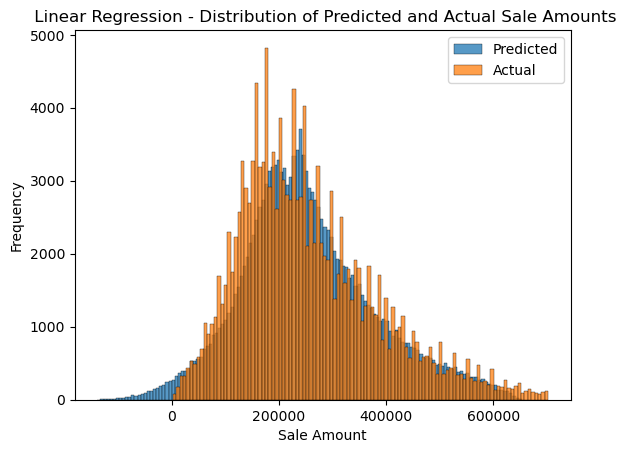

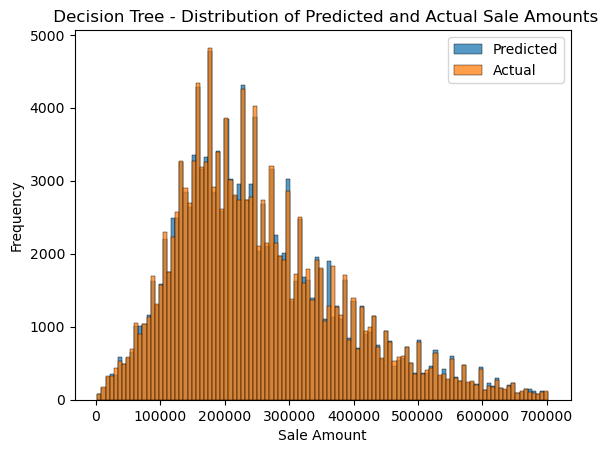

In [92]:
comparison_tree = pd.DataFrame(tree_predictions).round().join(actual_sales).rename(columns={0:'Predicted Sale Amount'})


import seaborn as sns
sns.histplot(comparison_lin['Predicted Sale Amount'], label='Predicted')
sns.histplot(comparison_lin['Sale Amount'], label='Actual')
plt.xlabel('Sale Amount')
plt.ylabel('Frequency')
plt.title(' Linear Regression - Distribution of Predicted and Actual Sale Amounts')
plt.legend()
plt.show()

sns.histplot(comparison_tree['Predicted Sale Amount'], label='Predicted')
sns.histplot(comparison_tree['Sale Amount'], label='Actual')
plt.xlabel('Sale Amount')
plt.ylabel('Frequency')
plt.title(' Decision Tree - Distribution of Predicted and Actual Sale Amounts')
plt.legend()
plt.show()



#### d. Applying Logistics Regression for categorical variable

In [93]:
#Perform data cleaning to group the Property Type into two values: Residential and Non-Residential

residential_types = ['Single Family', 'Condo', 'Two Family', 'Three Family', 'Four Family', 'Apartments']

data_log['Property Type'] = data_log['Property Type'].map(lambda x: 'Residential' if x in residential_types else 'Non-Residential')


data_log.reset_index(drop=True, inplace=True)

# Perform one-hot encoding on 'Property Type' and 'Town'
data_log_pt = data_log[["Property Type"]]
ordinal_encoder = OrdinalEncoder()
data_log_pt_encoded = ordinal_encoder.fit_transform(data_log_pt)

pt_encoder = OneHotEncoder()
data_log_pt_1hot = pt_encoder.fit_transform(data_log_pt)

pt_columns = pd.DataFrame(data_log_pt_1hot.toarray(), columns=['Residential', 'Non-Residential'])


data_log.reset_index(drop=True, inplace=True)
pt_columns.reset_index(drop=True, inplace=True)

data_log = data_log.join(pt_columns)

data_log["Town"] = data_log["Town"].str.strip()
data_log["Town"] = data_log["Town"].str.lower()
data_log_t = data_log[["Town"]]
ordinal_encoder = OrdinalEncoder()
data_log_t_encoded = ordinal_encoder.fit_transform(data_log_t)

t_encoder = OneHotEncoder()
data_log_t_1hot = t_encoder.fit_transform(data_log_t)
t_encoder.categories_
t_columns = pd.DataFrame(data_log_t_1hot.toarray(), columns=['***unknown***', 'andover', 'ansonia', 'ashford', 'avon',
        'barkhamsted', 'beacon falls', 'berlin', 'bethany', 'bethel',
        'bethlehem', 'bloomfield', 'bolton', 'bozrah', 'branford',
        'bridgeport', 'bridgewater', 'bristol', 'brookfield', 'brooklyn',
        'burlington', 'canaan', 'canterbury', 'canton', 'chaplin',
        'cheshire', 'chester', 'clinton', 'colchester', 'colebrook',
        'columbia', 'cornwall', 'coventry', 'cromwell', 'danbury',
        'darien', 'deep river', 'derby', 'durham', 'east granby',
        'east haddam', 'east hampton', 'east hartford', 'east haven',
        'east lyme', 'east windsor', 'eastford', 'easton', 'ellington',
        'enfield', 'essex', 'fairfield', 'farmington', 'franklin',
        'glastonbury', 'goshen', 'granby', 'greenwich', 'griswold',
        'groton', 'guilford', 'haddam', 'hamden', 'hampton', 'hartford',
        'hartland', 'harwinton', 'hebron', 'kent', 'killingly',
        'killingworth', 'lebanon', 'ledyard', 'lisbon', 'litchfield',
        'lyme', 'madison', 'manchester', 'mansfield', 'marlborough',
        'meriden', 'middlebury', 'middlefield', 'middletown', 'milford',
        'monroe', 'montville', 'morris', 'naugatuck', 'new britain',
        'new canaan', 'new fairfield', 'new hartford', 'new haven',
        'new london', 'new milford', 'newington', 'newtown', 'norfolk',
        'north branford', 'north canaan', 'north haven',
        'north stonington', 'norwalk', 'norwich', 'old lyme',
        'old saybrook', 'orange', 'oxford', 'plainfield', 'plainville',
        'plymouth', 'pomfret', 'portland', 'preston', 'prospect', 'putnam',
        'redding', 'ridgefield', 'rocky hill', 'roxbury', 'salem',
        'salisbury', 'scotland', 'seymour', 'sharon', 'shelton', 'sherman',
        'simsbury', 'somers', 'south windsor', 'southbury', 'southington',
        'sprague', 'stafford', 'stamford', 'sterling', 'stonington',
        'stratford', 'suffield', 'thomaston', 'thompson', 'tolland',
        'torrington', 'trumbull', 'union', 'vernon', 'voluntown',
        'wallingford', 'warren', 'washington', 'waterbury', 'waterford',
        'watertown', 'west hartford', 'west haven', 'westbrook', 'weston',
        'westport', 'wethersfield', 'willington', 'wilton', 'winchester',
        'windham', 'windsor', 'windsor locks', 'wolcott', 'woodbridge',
        'woodbury', 'woodstock'])

data_log = data_log.join(t_columns)

# Step 2: Split the Data
X = data_log.drop('Town', axis=1)
X = X.drop('Property Type', axis=1)  # Independent variables
y = data_log['Property Type']  # Dependent variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

# Step 3: Model Training
# Create and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 4: Model Evaluation
# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate classification report
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)

C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

Non-Residential       0.00      0.00      0.00       986
    Residential       0.99      1.00      1.00    146867

       accuracy                           0.99    147853
      macro avg       0.50      0.50      0.50    147853
   weighted avg       0.99      0.99      0.99    147853



C:\Users\nguye\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
